# CNN Classificators

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
#from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

import nltk
from numpy import asarray
from numpy import zeros
from keras.layers import Conv1D
import seaborn as sns

from datasets import load_dataset
import panel as pn
import warnings; warnings.filterwarnings('ignore')
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel
from keras.callbacks import EarlyStopping
from torch.nn import ReLU
from keras.layers import MaxPooling1D 

For this section, we implement a binary classification (positive/negative) and a multiclass classification (sadness, anger, love, surprise, fear, joy).

We introduce a second data set of movies reviews to be used for training the binary classifier, while the previously used dataset will still be used for the multiclass classification.

We will later analyze the predictions of both classifiers in both datasets to assess the distribution of multi-class feelings in the binary perception of the comment. In theory, our initial assumption is that sadness and anger should mostly match the negative binary classification, joy, and love should match the positive one, and perhaps surprise and fear could be more sparse among the classes.

## Data preparation

### Movies Reviews Dataset for Binary Classification

The maximum number of words in the movies dataset  is: 2470


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


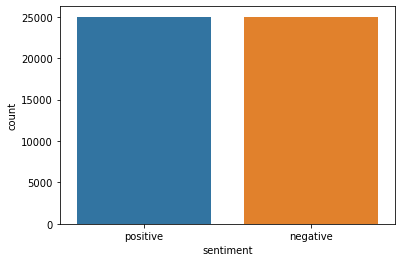

In [2]:
# Load the dataset into a DataFrame
movies_file_path = r'.\data\IMDB_Dataset.csv'
movie_reviews = pd.read_csv(movies_file_path)

#Remove nulls
movie_reviews.isnull().values.any()

#Show class distribution
sns.countplot(x='sentiment', data=movie_reviews)

max_words_count_movies = movie_reviews['review'].apply(lambda x: len(x.split())).max()
print(f"The maximum number of words in the movies dataset  is: {max_words_count_movies}")

movie_reviews

### Feelings Comments Dataset for Multiclass Classification

The original dataset was retrieved from https://huggingface.co/datasets/dair-ai/emotion. Further preprocessing was made to remove nulls and add the sentiment label name.

The maximum number of words in the feelings dataset is: 66


,text,label,sentiment
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


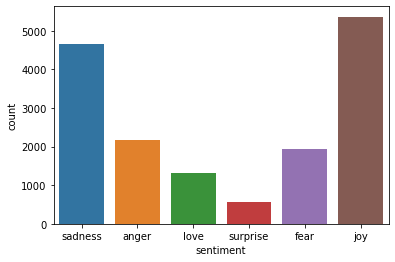

In [3]:
# Load the dataset into a DataFrame
feelings_file_path = r'.\data\preprocessed_feelings-training.csv'
feelings_train = pd.read_csv(feelings_file_path)

#Remove nulls
feelings_train.isnull().values.any()

#Show class distribution
sns.countplot(x='sentiment', data=feelings_train)

max_words_count_feelings = feelings_train['text'].apply(lambda x: len(x.split())).max()
print(f"The maximum number of words in the feelings dataset is: {max_words_count_feelings}")

feelings_train

### Preprocessing functions

For CNN, it is necessary to remove certain elements from the text such as stopwords and punctuations, since this will only introduce noise considering that this algorithm is not capable of inferring the context given by these elements. To do so, we use the functions below.

In [4]:
# The following code is adapted from the sentiment-analysis-with-deep-neural-networks repository by SkillCate
# Repository URL: https://github.com/skillcate/sentiment-analysis-with-deep-neural-networks
#----------

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)


nltk.download('stopwords')

def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

#----------

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
word_tokenizer = Tokenizer()

def prepare_datasets(df, X, y, maxlen):
    
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    #Prepare embedding layer
    # Train the tokenizer 
    word_tokenizer.fit_on_texts(X_train)

    # Convert sentences to their numeric form
    X_train = word_tokenizer.texts_to_sequences(X_train)
    X_test = word_tokenizer.texts_to_sequences(X_test)

    # Adding 1 to store dimensions for words for which no pretrained word embeddings exist
    vocab_length = len(word_tokenizer.word_index) + 1

    # Padding all reviews to have the same length
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    #padding='post' --> adds padding after the sentence
    #maxlen set to the max number of words to assure all sentences to fit and to have same lenght and

    # Load GloVe word embeddings and create an Embeddings Dictionary
    embeddings_dictionary = dict()
    glove_file = open(r'.\a2_glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    glove_file.close()

    # Create Embedding Matrix having 100 columns 
    # Containing 100-dimensional GloVe word embeddings for all words in our corpus.
    embedding_matrix = zeros((vocab_length, 100))
    for word, index in word_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    #100 dimensions --> the Glove emmbedding we use has 100 dimensions, so we keep the same number
    #trainable=False to allow Transfer learning: keep semantic information from pre-trained embeddings from GloVe. 

    return embedding_layer, X_train, X_test, y_train, y_test

## Binary Classification

In [6]:
class_mapping = {1: 'positive', 0: 'negative'}

# Calling preprocessing_text function on movie_reviews
X_movies = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X_movies.append(preprocess_text(sen))

# Converting sentiment labels to 0 & 1
y_movies = movie_reviews['sentiment']
y_movies = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_movies)))
 
# Check the lengths of X and y
print("Number of  X:", len(X_movies))
print("Number of y:", len(y_movies))
print("DF:", movie_reviews.shape)

movies_embedding_layer, movies_X_train, movies_X_test, movies_y_train, movies_y_test = prepare_datasets(movie_reviews, X_movies, y_movies, max_words_count_movies)

Number of  X: 50000
Number of y: 50000
DF: (50000, 2)



In [19]:
def evaluate_Binary_CNN(model, model_history, X_test, y_test):
    
    score = model.evaluate(X_test, y_test, verbose=1)
    # Model Performance

    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])

    # Model Performance Charts

    import matplotlib.pyplot as plt

    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()

    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()
    return score


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d (Conv1D)             (None, 2466, 128)         64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/6


1000/1000 [==============================] - 159s 158ms/step

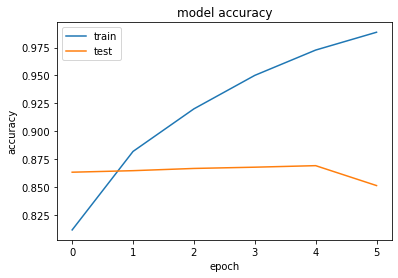

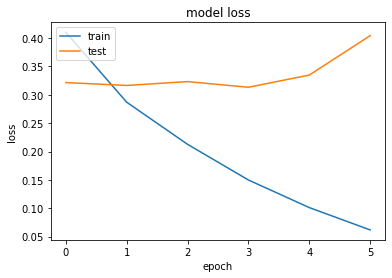

In [8]:
def train_Binary_CNN_Original(embedding_layer, X_train, y_train, filters=128, kernel = 5, epochs =6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    #add a 1D convolutional layer
    # padding was pre-done so no need for further modifications on it
    #filters = 128 --> number of patterns to learn
    #kernel_size = 5 ---> words considered at once
    #ReLu --> to introduce non linearity 
    cnn_model.add(Conv1D(filters, kernel, activation='relu'))
    
    #Extract most important feature, Maxpool shows better performance for NLP
    #Samat, Nurul Ashikin & Salleh, Mohd & Ali, Haseeb. (2020). The Comparison of Pooling Functions in Convolutional Neural Network for Sentiment Analysis Task. 10.1007/978-3-030-36056-6_20. 
    cnn_model.add(GlobalMaxPooling1D()) 
    
    cnn_model.add(Dense(1, activation='sigmoid'))
    #Only 1 output layer needed for binary classification
    #Sigmoid activation function squashes the output to the range [0, 1]

    # Model compiling
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())
    
    # Create an EarlyStopping callback
    #early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    # The 'patience' parameter determines the number of epochs with no improvement after which training will be stopped.
    # 'monitor' specifies the metric to monitor for improvement. In this case, it's validation loss.
    # 'restore_best_weights' restores the model weights from the epoch with the best value of the monitored quantity.
    
    
    # Train the model with the callback
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

    return cnn_model, cnn_model_history

cnn_model1, cnn_model_history1 = train_Binary_CNN_Original(movies_embedding_layer, movies_X_train, movies_y_train)
evaluate_Binary_CNN(cnn_model1, cnn_model_history1, movies_X_test, movies_y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_1 (Conv1D)           (None, 2466, 128)         64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 159s 159ms/ste

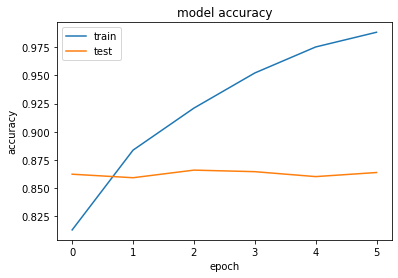

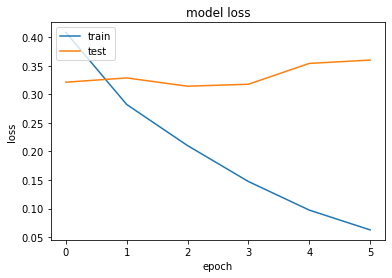

In [9]:
def train_Binary_CNN_Original_earlystop(embedding_layer, X_train, y_train, filters=128, kernel = 5, epochs =6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    #add a 1D convolutional layer
    # padding was pre-done so no need for further modifications on it
    #filters = 128 --> number of patterns to learn
    #kernel_size = 5 ---> words considered at once
    #ReLu --> to introduce non linearity 
    cnn_model.add(Conv1D(filters, kernel, activation='relu'))
    
    #Extract most important feature, Maxpool shows better performance for NLP
    #Samat, Nurul Ashikin & Salleh, Mohd & Ali, Haseeb. (2020). The Comparison of Pooling Functions in Convolutional Neural Network for Sentiment Analysis Task. 10.1007/978-3-030-36056-6_20. 
    cnn_model.add(GlobalMaxPooling1D()) 
    
    cnn_model.add(Dense(1, activation='sigmoid'))
    #Only 1 output layer needed for binary classification
    #Sigmoid activation function squashes the output to the range [0, 1]

    # Model compiling
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())
    
    # Create an EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    # The 'patience' parameter determines the number of epochs with no improvement after which training will be stopped.
    # 'monitor' specifies the metric to monitor for improvement. In this case, it's validation loss.
    # 'restore_best_weights' restores the model weights from the epoch with the best value of the monitored quantity.
    
    
    # Train the model with the callback
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

cnn_model2, cnn_model_history2 = train_Binary_CNN_Original_earlystop(movies_embedding_layer, movies_X_train, movies_y_train)
evaluate_Binary_CNN(cnn_model2, cnn_model_history2, movies_X_test, movies_y_test)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_2 (Conv1D)           (None, 2466, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 1233, 128)         0         
 D)                                                              
                                                                 
 conv1d_3 (Conv1D)           (None, 1229, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 614, 128)          0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)             

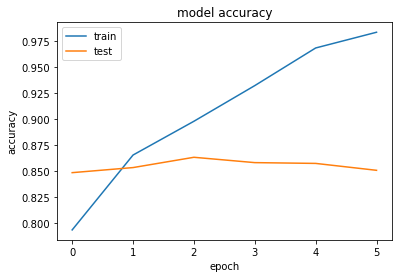

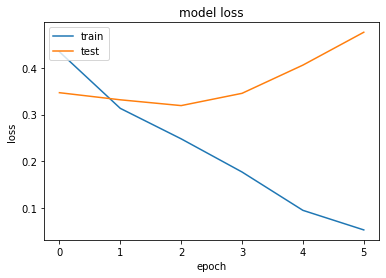

In [10]:
def train_Binary_CNN(embedding_layer, X_train, y_train, filters=128, kernel=5, num_conv_layers=2, epochs=6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    for _ in range(num_conv_layers):
        cnn_model.add(Conv1D(filters, kernel, activation='relu'))
        #Max Pooling reduces spatial dimensions and captures local features effectively. --> local info

        cnn_model.add(MaxPooling1D())
        
    #Global Max Pooling summarizes the most important global features.--> global info
    cnn_model.add(GlobalMaxPooling1D()) 
    
    cnn_model.add(Dense(1, activation='sigmoid'))

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

# Example usage with two convolutional layers
cnn_model3, cnn_model_history3 = train_Binary_CNN(movies_embedding_layer, movies_X_train, movies_y_train, num_conv_layers=2)
evaluate_Binary_CNN(cnn_model3, cnn_model_history3, movies_X_test, movies_y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_4 (Conv1D)           (None, 2466, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1233, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1229, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 614, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 610, 128)         

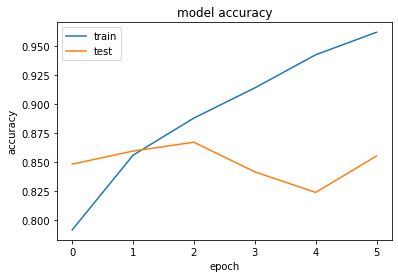

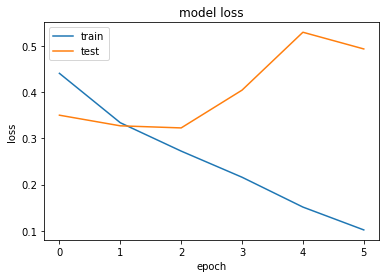

In [11]:
# 4 convolution-pooling pairs
cnn_model4, cnn_model_history4 = train_Binary_CNN(movies_embedding_layer, movies_X_train, movies_y_train, num_conv_layers=4)
evaluate_Binary_CNN(cnn_model4, cnn_model_history4, movies_X_test, movies_y_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_8 (Conv1D)           (None, 2466, 128)         64128     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1233, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 1229, 128)         82048     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 614, 128)          0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 78592)            

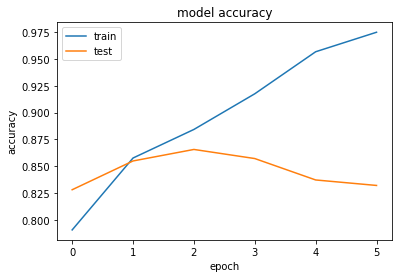

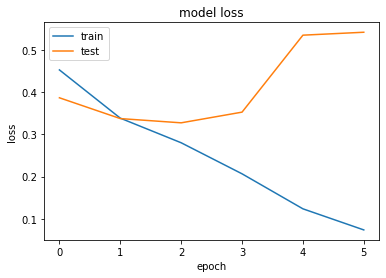

In [12]:
from keras.layers import Flatten 

def train_Binary_CNN_flattening(embedding_layer, X_train, y_train, filters=128, kernel=5, num_conv_layers=2, epochs=6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    for _ in range(num_conv_layers):
        cnn_model.add(Conv1D(filters, kernel, activation='relu'))
        cnn_model.add(MaxPooling1D())
    
    cnn_model.add(Flatten()) 
    
    cnn_model.add(Dense(1, activation='sigmoid'))

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

# Example usage with two convolutional layers + flattening instead of global maxpool
cnn_model5, cnn_model_history5 = train_Binary_CNN_flattening(movies_embedding_layer, movies_X_train, movies_y_train, num_conv_layers=2)
evaluate_Binary_CNN(cnn_model5, cnn_model_history5, movies_X_test, movies_y_test)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_12 (Conv1D)          (None, 2468, 64)          19264     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9258729 (35.32 MB)
Trainable params: 19329 (75.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 75s 74ms/step -

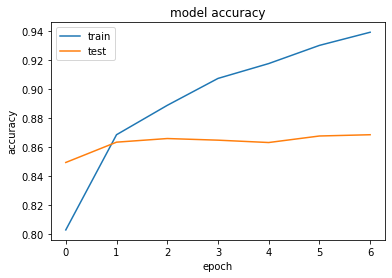

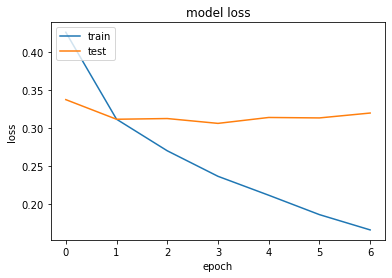

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_13 (Conv1D)          (None, 2466, 64)          32064     
                                                                 
 global_max_pooling1d_7 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9271529 (35.37 MB)
Trainable params: 32129 (125.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 103s 102ms/ste

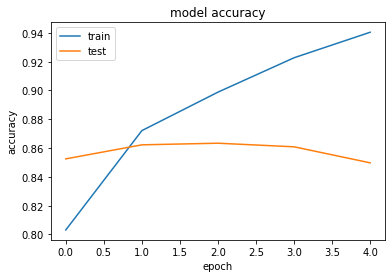

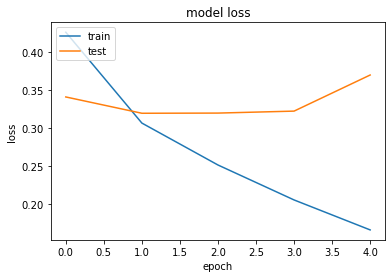

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_14 (Conv1D)          (None, 2464, 64)          44864     
                                                                 
 global_max_pooling1d_8 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9284329 (35.42 MB)
Trainable params: 44929 (175.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 108s 108ms/st

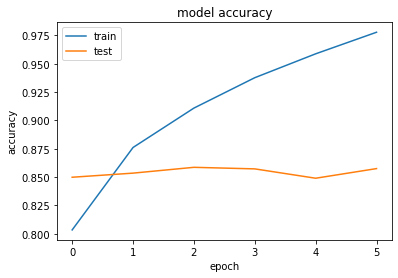

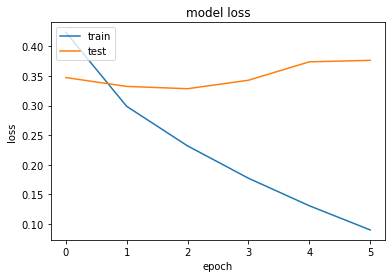

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_15 (Conv1D)          (None, 2468, 128)         38528     
                                                                 
 global_max_pooling1d_9 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9278057 (35.39 MB)
Trainable params: 38657 (151.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 123s 122ms/st

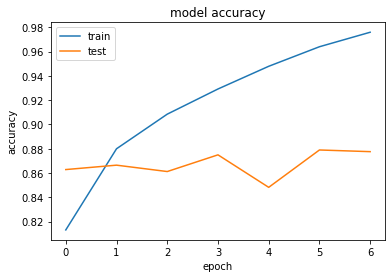

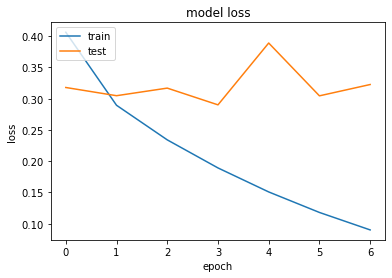

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_16 (Conv1D)          (None, 2466, 128)         64128     
                                                                 
 global_max_pooling1d_10 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 179s 178ms/st

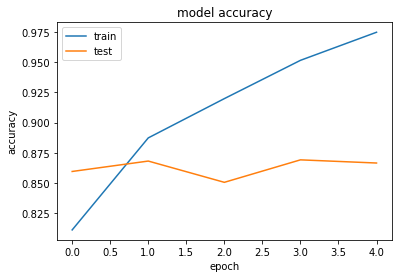

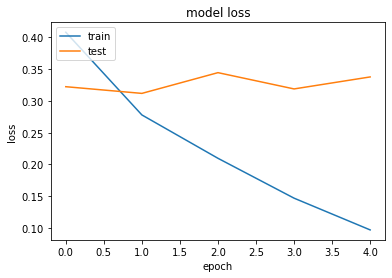

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_17 (Conv1D)          (None, 2464, 128)         89728     
                                                                 
 global_max_pooling1d_11 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 9329257 (35.59 MB)
Trainable params: 89857 (351.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 225s 224ms/st

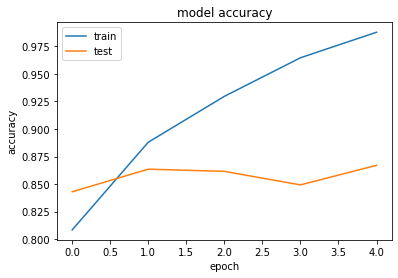

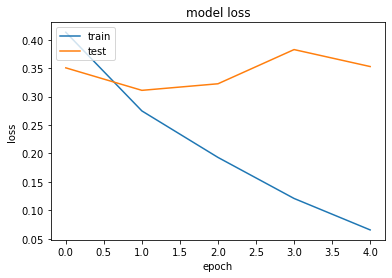

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_18 (Conv1D)          (None, 2468, 256)         77056     
                                                                 
 global_max_pooling1d_12 (G  (None, 256)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 9316713 (35.54 MB)
Trainable params: 77313 (302.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 315s 314ms/st

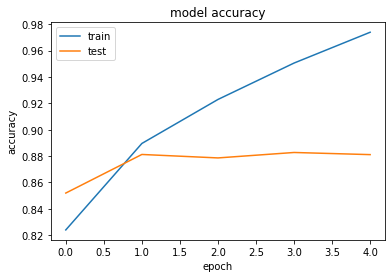

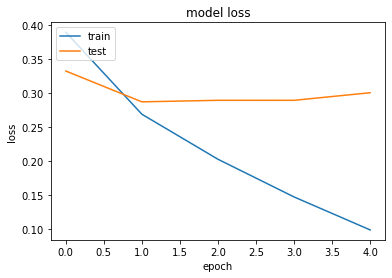

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_19 (Conv1D)          (None, 2466, 256)         128256    
                                                                 
 global_max_pooling1d_13 (G  (None, 256)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_14 (Dense)            (None, 1)                 257       
                                                                 
Total params: 9367913 (35.74 MB)
Trainable params: 128513 (502.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 329s 327ms/s

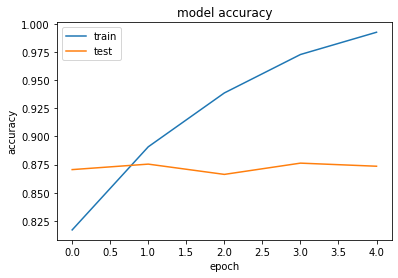

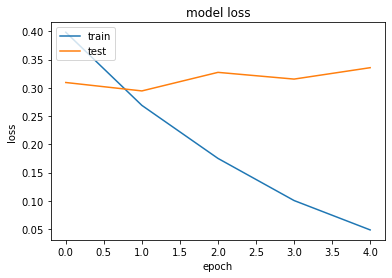

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2470, 100)         9239400   
                                                                 
 conv1d_20 (Conv1D)          (None, 2464, 256)         179456    
                                                                 
 global_max_pooling1d_14 (G  (None, 256)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 9419113 (35.93 MB)
Trainable params: 179713 (702.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None
Epoch 1/100
1000/1000 [==============================] - 425s 425ms/s

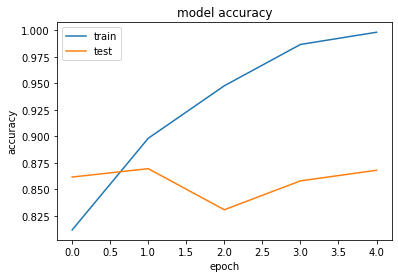

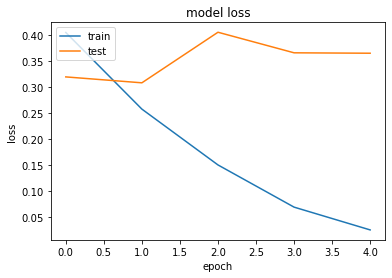

   Filters  Kernel_Size  Accuracy      Loss
0       64            3    0.8675  0.311258
1       64            5    0.8591  0.322366
2       64            7    0.8571  0.328349
3      128            3    0.8720  0.299619
4      128            5    0.8665  0.314189
5      128            7    0.8623  0.322949
6      256            3    0.8782  0.292162
7      256            5    0.8690  0.302957
8      256            7    0.8702  0.308041


In [20]:
def evaluate_hyperparameters(filter_values, kernel_sizes, X_train, y_train, X_test, y_test, embedding_layer):
    results = []

    for filters in filter_values:
        for kernel in kernel_sizes:
            model, history = train_Binary_CNN_Original_earlystop(embedding_layer, X_train, y_train, filters, kernel, epochs=6)
            evaluation = evaluate_Binary_CNN(model, history, X_test, y_test)
            accuracy = evaluation[1]  
            loss = evaluation[0] 

            # Store results in a dictionary
            result = {
                'Filters': filters,
                'Kernel_Size': kernel,
                'Accuracy': accuracy,
                'Loss': loss
               
            }
            results.append(result)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define ranges
filter_values = [64, 128, 256]
kernel_sizes = [3, 5, 7]

# Run the hyperparameter optimization and get the DataFrame
results_df = evaluate_hyperparameters(filter_values, kernel_sizes, movies_X_train, movies_y_train, movies_X_test, movies_y_test, movies_embedding_layer)
print(results_df)


## Multiclass Clasification

In [13]:
multiclass_df = feelings_train.copy()
multiclass_df.isnull().values.any()
multiclass_df = pd.get_dummies(multiclass_df, columns=['sentiment'], prefix='sentiment')
multiclass_df

,text,label,sentiment_anger,sentiment_fear,sentiment_joy,sentiment_love,sentiment_sadness,sentiment_surprise
0,i didnt feel humiliated,0,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,3,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,2,0,0,0,1,0,0
4,i am feeling grouchy,3,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,0,0,0,0,1,0
15996,i am now turning and i feel pathetic that i am...,0,0,0,0,0,1,0
15997,i feel strong and good overall,1,0,0,1,0,0,0
15998,i feel like this was such a rude comment and i...,3,1,0,0,0,0,0


In [22]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

maxlen = max_words_count_feelings

def prepare_multiclass_datasets(multiclass_df):
    X = []
    sentences = list(multiclass_df['text'])
    for sen in sentences:
        X.append(preprocess_text(sen))

    y = multiclass_df[['sentiment_anger', 'sentiment_fear', 'sentiment_joy', 'sentiment_love', 'sentiment_sadness', 'sentiment_surprise']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    # Tokenization and padding
    word_tokenizer.fit_on_texts(X_train)
    X_train = word_tokenizer.texts_to_sequences(X_train)
    X_test = word_tokenizer.texts_to_sequences(X_test)
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    vocab_length = len(word_tokenizer.word_index) + 1

    # Load GloVe word embeddings and create an Embeddings Dictionary
    embeddings_dictionary = dict()
    glove_file = open(r'.\a2_glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

    glove_file.close()

    embedding_matrix = zeros((vocab_length, 100))
    for word, index in word_tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

    return embedding_layer, X_train, X_test, y_train, y_test

embedding_layer_emotions, X_train_emotions, X_test_emotions, y_train_emotions, y_test_emotions = prepare_multiclass_datasets(multiclass_df)
y_train_emotions

,sentiment_anger,sentiment_fear,sentiment_joy,sentiment_love,sentiment_sadness,sentiment_surprise
676,0,0,1,0,0,0
12113,0,0,0,0,1,0
7077,0,0,0,1,0,0
13005,0,0,0,0,1,0
12123,1,0,0,0,0,0
...,...,...,...,...,...,...
13418,0,1,0,0,0,0
5390,0,0,0,1,0,0
860,0,0,0,0,1,0
15795,0,0,0,0,1,0


Epoch 1/6
80/80 [==============================] - 2s 18ms/step - loss: 1.3128 - acc: 0.5188 - val_loss: 1.1130 - val_acc: 0.5844
Epoch 2/6
80/80 [==============================] - 1s 14ms/step - loss: 0.8837 - acc: 0.6901 - val_loss: 0.8720 - val_acc: 0.6805
Epoch 3/6
80/80 [==============================] - 1s 14ms/step - loss: 0.6574 - acc: 0.7788 - val_loss: 0.7423 - val_acc: 0.7352
Epoch 4/6
80/80 [==============================] - 1s 15ms/step - loss: 0.5081 - acc: 0.8406 - val_loss: 0.6603 - val_acc: 0.7590
Epoch 5/6
80/80 [==============================] - 1s 17ms/step - loss: 0.4068 - acc: 0.8823 - val_loss: 0.6167 - val_acc: 0.7637
Epoch 6/6
100/100 [==============================] - 0s 3ms/step - loss: 0.5756 - acc: 0.7847
Test Score: 0.5755776166915894
Test Accuracy: 0.7846875190734863


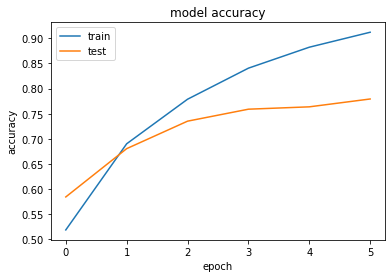

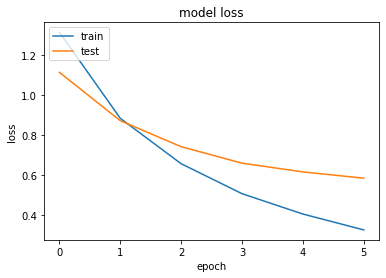

[0.5755776166915894, 0.7846875190734863]

In [23]:

def train_Multiclass_CNN_Original(embedding_layer, X_train, y_train):
    # Define the model
    cnn_multiclass_model = Sequential()
    cnn_multiclass_model.add(embedding_layer)
    cnn_multiclass_model.add(Conv1D(128, 5, activation='relu'))
    cnn_multiclass_model.add(GlobalMaxPooling1D())
    cnn_multiclass_model.add(Dense(len(y_train.columns), activation='softmax')) #One output neuron per class

    # Compile the model
    cnn_multiclass_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    # Train the model
    cnn_multiclass_model_history = cnn_multiclass_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

    return cnn_multiclass_model, cnn_multiclass_model_history

cnn_multiclass_model1, cnn_multiclass_model_history1 = train_Multiclass_CNN_Original(embedding_layer_emotions, X_train_emotions, y_train_emotions)
evaluate_Binary_CNN(cnn_multiclass_model1, cnn_multiclass_model_history1, X_test_emotions, y_test_emotions)

Epoch 1/100
320/320 [==============================] - 2s 7ms/step - loss: 1.1054 - acc: 0.5934 - val_loss: 0.8733 - val_acc: 0.6660
Epoch 2/100
320/320 [==============================] - 2s 6ms/step - loss: 0.6066 - acc: 0.7917 - val_loss: 0.6680 - val_acc: 0.7469
Epoch 3/100
320/320 [==============================] - 2s 6ms/step - loss: 0.4041 - acc: 0.8710 - val_loss: 0.5873 - val_acc: 0.7812
Epoch 4/100
320/320 [==============================] - 2s 6ms/step - loss: 0.2740 - acc: 0.9229 - val_loss: 0.5457 - val_acc: 0.7902
Epoch 5/100
320/320 [==============================] - 2s 6ms/step - loss: 0.1850 - acc: 0.9578 - val_loss: 0.5339 - val_acc: 0.7957
Epoch 6/100
320/320 [==============================] - 2s 6ms/step - loss: 0.1297 - acc: 0.9753 - val_loss: 0.5360 - val_acc: 0.8039
Epoch 7/100
320/320 [==============================] - 2s 6ms/step - loss: 0.0915 - acc: 0.9867 - val_loss: 0.5607 - val_acc: 0.7969
Epoch 8/100
320/320 [==============================] - 2s 6ms/step - 

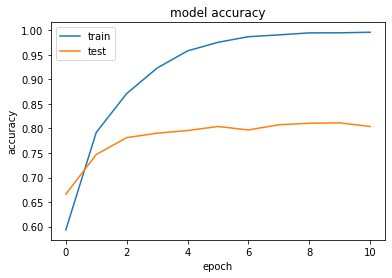

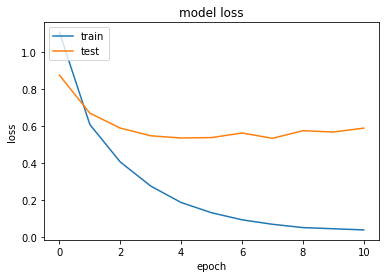

[0.5185458660125732, 0.8181250095367432]

In [26]:
def train_Multiclass_CNN_Original_earlystop(embedding_layer, X_train, y_train):
    # Define the model
    cnn_multiclass_model = Sequential()
    cnn_multiclass_model.add(embedding_layer)
    cnn_multiclass_model.add(Conv1D(128, 5, activation='relu'))
    cnn_multiclass_model.add(GlobalMaxPooling1D())
    cnn_multiclass_model.add(Dense(len(y_train.columns), activation='softmax')) #One output neuron per class

    # Compile the model
    cnn_multiclass_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


    # Train the model
    cnn_multiclass_model_history = cnn_multiclass_model.fit(X_train, y_train, callbacks=[early_stopping], epochs=100, validation_split=0.2)

    return cnn_multiclass_model, cnn_multiclass_model_history

cnn_multiclass_model2, cnn_multiclass_model_history2 = train_Multiclass_CNN_Original_earlystop(embedding_layer_emotions, X_train_emotions, y_train_emotions)
evaluate_Binary_CNN(cnn_multiclass_model2, cnn_multiclass_model_history2, X_test_emotions, y_test_emotions)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 66, 100)           9388800   
                                                                 
 conv1d_27 (Conv1D)          (None, 62, 128)           64128     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 31, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 27, 128)           82048     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 13, 128)           0         
 ng1D)                                                           
                                                                 
 global_max_pooling1d_20 (G  (None, 128)             

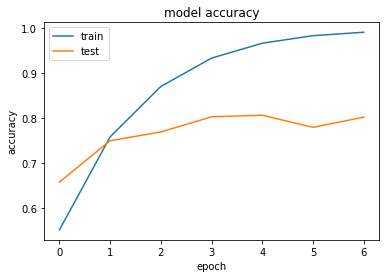

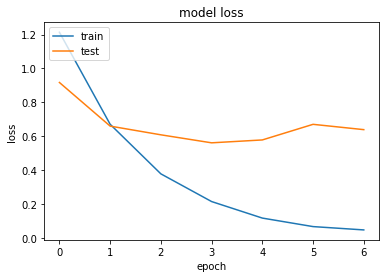

[0.5264419913291931, 0.817187488079071]

In [29]:
def train_Multiclass_CNN(embedding_layer, X_train, y_train, filters=128, kernel=5, num_conv_layers=2, epochs=6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    for _ in range(num_conv_layers):
        cnn_model.add(Conv1D(filters, kernel, activation='relu'))
        cnn_model.add(MaxPooling1D())
    
    cnn_model.add(GlobalMaxPooling1D()) 
    
    cnn_model.add(Dense(len(y_train.columns), activation='sigmoid'))

    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    print(cnn_model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

cnn_multiclass_model3, cnn_multiclass_model_history3 = train_Multiclass_CNN(embedding_layer_emotions, X_train_emotions, y_train_emotions)
evaluate_Binary_CNN(cnn_multiclass_model3, cnn_multiclass_model_history3, X_test_emotions, y_test_emotions)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 66, 100)           9388800   
                                                                 
 conv1d_33 (Conv1D)          (None, 62, 128)           64128     
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 31, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_34 (Conv1D)          (None, 27, 128)           82048     
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 13, 128)           0         
 ng1D)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 1664)            

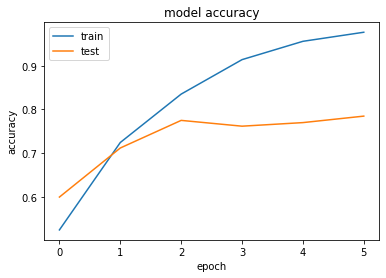

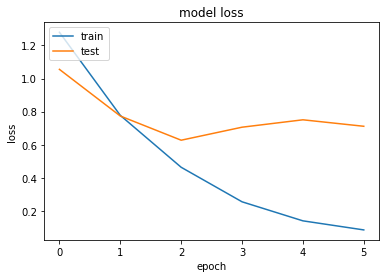

[0.6178933382034302, 0.7787500023841858]

In [32]:
def train_Multiclass_CNN_flattening(embedding_layer, X_train, y_train, filters=128, kernel=5, num_conv_layers=2, epochs=6):
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    
    for _ in range(num_conv_layers):
        cnn_model.add(Conv1D(filters, kernel, activation='relu'))
        cnn_model.add(MaxPooling1D())
    
    cnn_model.add(Flatten()) 
    
    cnn_model.add(Dense(len(y_train.columns), activation='sigmoid'))

    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    print(cnn_model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    cnn_model_history = cnn_model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_split=0.2)

    return cnn_model, cnn_model_history

cnn_multiclass_model5, cnn_multiclass_model_history5 = train_Multiclass_CNN_flattening(embedding_layer_emotions, X_train_emotions, y_train_emotions)
evaluate_Binary_CNN(cnn_multiclass_model5, cnn_multiclass_model_history5, X_test_emotions, y_test_emotions)

# Datasets Cross

In [37]:
def analyseSentenseBinaryCCN(new_sentence, model, maxlen):
    # Tokenize and convert to numeric form
    new_sentence_seq = word_tokenizer.texts_to_sequences([new_sentence])
    
    # Padding the new sentence to match the maxlen used during training
    padded_new_sentence = pad_sequences(new_sentence_seq, padding='post', maxlen=maxlen)

    # Predict the sentiment probabilities
    predicted_probabilities = model.predict(padded_new_sentence)
    predicted_probabilities_rounded =  np.round(predicted_probabilities).astype(int)
    

    # Find the class with the maximum probability
    predicted_sentiment = np.argmax(predicted_probabilities_rounded, axis=1)
    '''
    print("new_sentence_seq:", new_sentence_seq)
    print("padded_new_sentence:", padded_new_sentence)
    print("Predicted Sentiment:", predicted_sentiment)
    print("Predicted Probabilities:", predicted_probabilities)
    print("predicted_probabilities_rounded", predicted_probabilities_rounded)
    '''
    # Map the predicted sentiment to the corresponding class or label
    predicted_class = class_mapping[int(predicted_probabilities_rounded[0])]

    print("Predicted Class:", predicted_class, " at", float(predicted_probabilities)*100, "% ")
    return predicted_class

analyseSentenseBinaryCCN("this was very red", cnn_model2, max_words_count_movies)

1/1 [==============================] - 0s 59ms/step
Predicted Class: positive  at 72.49616384506226 % 


'positive'

In [41]:
# Initialize an empty list to store the results
feelings_results = []

# Iterate through the rows of feelings_train
for index, row in feelings_train.iterrows():
    text = row['text']
    sentiment = row['sentiment']
    # Replace 'model' with your trained CNN model
    predicted_sentiment = analyseSentenseBinaryCCN(text, cnn_model2, max_words_count_movies)
    
    # Append the results to the list
    feelings_results.append([text, sentiment, predicted_sentiment])

# Create a new DataFrame 'datasetsCross' with the results
datasetsCross = pd.DataFrame(feelings_results, columns=['text', 'sentiment', 'predicted_sentiment'])

# Print the first few rows of datasetsCross to check the results
print(datasetsCross.head())


1/1 [==============================] - 0s 20ms/step
Predicted Class: positive  at 81.05643391609192 % 
1/1 [==============================] - 0s 22ms/step
Predicted Class: negative  at 37.569016218185425 % 
1/1 [==============================] - 0s 16ms/step
Predicted Class: positive  at 99.66480731964111 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: positive  at 96.43166065216064 % 
1/1 [==============================] - 0s 23ms/step
Predicted Class: negative  at 16.00295752286911 % 
1/1 [==============================] - 0s 25ms/step
Predicted Class: positive  at 59.175240993499756 % 
1/1 [==============================] - 0s 13ms/step
Predicted Class: positive  at 87.93847560882568 % 
1/1 [==============================] - 0s 31ms/step
Predicted Class: positive  at 85.52127480506897 % 
1/1 [==============================] - 0s 23ms/step
Predicted Class: negative  at 14.675527811050415 % 
1/1 [==============================] - 0s 25ms/step
Predicted Class: p

1/1 [==============================] - 0s 21ms/step
Predicted Class: negative  at 25.321266055107117 % 
1/1 [==============================] - 0s 17ms/step
Predicted Class: positive  at 99.85648393630981 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: positive  at 99.31597113609314 % 
1/1 [==============================] - 0s 23ms/step
Predicted Class: negative  at 3.123307414352894 % 
1/1 [==============================] - 0s 23ms/step
Predicted Class: negative  at 3.984406590461731 % 
1/1 [==============================] - 0s 22ms/step
Predicted Class: negative  at 12.29093223810196 % 
1/1 [==============================] - 0s 20ms/step
Predicted Class: negative  at 8.36515799164772 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: positive  at 99.38219785690308 % 
1/1 [==============================] - 0s 24ms/step
Predicted Class: positive  at 59.38290357589722 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: posi

1/1 [==============================] - 0s 22ms/step
Predicted Class: positive  at 99.79537725448608 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: positive  at 75.82165002822876 % 
1/1 [==============================] - 0s 19ms/step
Predicted Class: positive  at 97.86296486854553 % 
1/1 [==============================] - 0s 38ms/step
Predicted Class: positive  at 93.41784119606018 % 
1/1 [==============================] - 0s 17ms/step
Predicted Class: positive  at 99.76162314414978 % 
1/1 [==============================] - 0s 17ms/step
Predicted Class: negative  at 3.884970396757126 % 
1/1 [==============================] - 0s 17ms/step
Predicted Class: positive  at 95.43566107749939 % 
1/1 [==============================] - 0s 20ms/step
Predicted Class: positive  at 64.66507911682129 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: positive  at 74.67044591903687 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: nega

Predicted Class: positive  at 99.82517957687378 % 
1/1 [==============================] - 0s 22ms/step
Predicted Class: positive  at 98.55049848556519 % 
1/1 [==============================] - 0s 16ms/step
Predicted Class: positive  at 65.15782475471497 % 
1/1 [==============================] - 0s 19ms/step
Predicted Class: positive  at 77.57380604743958 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: negative  at 21.78223878145218 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: positive  at 97.74561524391174 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: negative  at 44.274258613586426 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: positive  at 61.58313751220703 % 
1/1 [==============================] - 0s 17ms/step
Predicted Class: negative  at 32.1490079164505 % 
1/1 [==============================] - 0s 23ms/step
Predicted Class: positive  at 76.06033682823181 % 
1/1 [=================

1/1 [==============================] - 0s 31ms/step
Predicted Class: positive  at 91.7745590209961 % 
1/1 [==============================] - 0s 7ms/step
Predicted Class: negative  at 11.029130220413208 % 
1/1 [==============================] - 0s 18ms/step
Predicted Class: positive  at 98.01244139671326 % 
1/1 [==============================] - 0s 26ms/step
Predicted Class: negative  at 10.957245528697968 % 
1/1 [==============================] - 0s 22ms/step
Predicted Class: negative  at 2.0330367609858513 % 
1/1 [==============================] - 0s 22ms/step
Predicted Class: positive  at 78.58776450157166 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: negative  at 22.339460253715515 % 
1/1 [==============================] - 0s 17ms/step
Predicted Class: positive  at 97.83676266670227 % 
1/1 [==============================] - 0s 22ms/step
Predicted Class: positive  at 99.06968474388123 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: ne

1/1 [==============================] - 0s 21ms/step
Predicted Class: negative  at 1.2580730952322483 % 
1/1 [==============================] - 0s 33ms/step
Predicted Class: positive  at 67.9317831993103 % 
1/1 [==============================] - 0s 16ms/step
Predicted Class: positive  at 76.37786269187927 % 
1/1 [==============================] - 0s 20ms/step
Predicted Class: negative  at 35.21760702133179 % 
1/1 [==============================] - 0s 33ms/step
Predicted Class: negative  at 0.12120809406042099 % 
1/1 [==============================] - 0s 21ms/step
Predicted Class: negative  at 21.07611447572708 % 
1/1 [==============================] - 0s 34ms/step
Predicted Class: negative  at 10.847881436347961 % 
1/1 [==============================] - 0s 22ms/step
Predicted Class: positive  at 97.7257788181305 % 
1/1 [==============================] - 0s 10ms/step
Predicted Class: positive  at 77.73026823997498 % 
1/1 [==============================] - 0s 23ms/step
Predicted Class: po

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding/embedding_lookup defined at (most recent call last):
  File "C:\Users\maria\anaconda3\lib\runpy.py", line 197, in _run_module_as_main

  File "C:\Users\maria\anaconda3\lib\runpy.py", line 87, in _run_code

  File "C:\Users\maria\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>

  File "C:\Users\maria\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance

  File "C:\Users\maria\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start

  File "C:\Users\maria\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start

  File "C:\Users\maria\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever

  File "C:\Users\maria\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once

  File "C:\Users\maria\anaconda3\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\maria\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue

  File "C:\Users\maria\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one

  File "C:\Users\maria\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell

  File "C:\Users\maria\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request

  File "C:\Users\maria\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute

  File "C:\Users\maria\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell

  File "C:\Users\maria\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell

  File "C:\Users\maria\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell

  File "C:\Users\maria\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\maria\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async

  File "C:\Users\maria\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes

  File "C:\Users\maria\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code

  File "C:\Users\maria\AppData\Local\Temp\ipykernel_14840\1015053605.py", line 28, in <cell line: 28>

  File "C:\Users\maria\AppData\Local\Temp\ipykernel_14840\1015053605.py", line 9, in analyseSentenseBinaryCCN

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\maria\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[0,5] = 92476 is not in [0, 92394)
	 [[{{node sequential_1/embedding/embedding_lookup}}]] [Op:__inference_predict_function_559476]